#0) Imports and Installs

In [371]:
!pip install -r ../requirements.txt

In [372]:
import time
from datetime import date


import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

# for graphs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


import requests
import eurostat
import re
import talib

# 1) [Code Snippet 1] IPOs data from Web

* learn dataframes "stacking" (UNION ALL)
* learn about type casting
* generate new columns (simple and with function)


In [373]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/2023/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

/var/folders/9t/gnjff14n4zq228dml1fm7v_w0000gn/T/ipykernel_87445/3740329921.py:8: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [374]:
ipos_2023 = ipo_dfs[0]
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      154 non-null    object
 1   Symbol        154 non-null    object
 2   Company Name  154 non-null    object
 3   IPO Price     154 non-null    object
 4   Current       154 non-null    object
 5   Return        154 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [375]:
url = "https://stockanalysis.com/ipos/2024/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

/var/folders/9t/gnjff14n4zq228dml1fm7v_w0000gn/T/ipykernel_87445/1522156903.py:4: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [376]:
ipos_2024 = ipo_dfs[0]
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      65 non-null     object
 1   Symbol        65 non-null     object
 2   Company Name  65 non-null     object
 3   IPO Price     65 non-null     object
 4   Current       65 non-null     object
 5   Return        65 non-null     object
dtypes: object(6)
memory usage: 3.2+ KB


In [377]:
# "stacking dataframes"
# pd.concat() is used to concatenate the DataFrames vertically.
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
# ignoring the original indices of the input DataFrames.
# The stacked_df now contains the concatenated DataFrame.
stacked_ipos_df = pd.concat([ipos_2024, ipos_2023], ignore_index=True)
stacked_ipos_df.head()

IPO Date Symbol               Company Name IPO Price Current   Return
0   May 8, 2024    NNE   Nano Nuclear Energy Inc.     $4.00   $5.18   29.75%
1   May 1, 2024    VIK       Viking Holdings Ltd.    $24.00  $28.69   19.54%
2  Apr 26, 2024   ZONE  CleanCore Solutions, Inc.     $4.00   $3.18  -20.75%
3  Apr 25, 2024   RBRK               Rubrik, Inc.    $32.00  $33.58    4.91%
4  Apr 25, 2024   LOAR         Loar Holdings Inc.    $28.00  $47.88   73.86%

In [378]:
# Need to convert everything to a proper type (date, str, int, float, etc.)
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      219 non-null    object
 1   Symbol        219 non-null    object
 2   Company Name  219 non-null    object
 3   IPO Price     219 non-null    object
 4   Current       219 non-null    object
 5   Return        219 non-null    object
dtypes: object(6)
memory usage: 10.4+ KB


In [379]:
# convert to datetime
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'], format="%b %d, %Y")
stacked_ipos_df.head()

IPO Date Symbol               Company Name IPO Price Current   Return
0 2024-05-08    NNE   Nano Nuclear Energy Inc.     $4.00   $5.18   29.75%
1 2024-05-01    VIK       Viking Holdings Ltd.    $24.00  $28.69   19.54%
2 2024-04-26   ZONE  CleanCore Solutions, Inc.     $4.00   $3.18  -20.75%
3 2024-04-25   RBRK               Rubrik, Inc.    $32.00  $33.58    4.91%
4 2024-04-25   LOAR         Loar Holdings Inc.    $28.00  $47.88   73.86%

In [380]:
# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df

Empty DataFrame
Columns: [IPO Date, Symbol, Company Name, IPO Price, Current, Return]
Index: []

In [381]:
# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])

In [382]:
# Convert "Current" column
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100

In [383]:
# Correctly applied transformations with 'defensive' techniques, but now not all are non-null
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      219 non-null    datetime64[ns]
 1   Symbol        219 non-null    object        
 2   Company Name  219 non-null    object        
 3   IPO Price     219 non-null    float64       
 4   Current       219 non-null    float64       
 5   Return        217 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.4+ KB


In [384]:
# simple way of checking NULLs
# (you need to understand how vector operations work .isnull() and calls chaining .isnull().sum())
stacked_ipos_df.isnull().sum()

IPO Date        0
Symbol          0
Company Name    0
IPO Price       0
Current         0
Return          2
dtype: int64

In [385]:
# Do you want to leave the record or not?
stacked_ipos_df[stacked_ipos_df.Return.isnull()]

IPO Date Symbol     Company Name  IPO Price  Current  Return
5   2024-04-25    MRX  Marex Group plc      19.00    19.01     NaN
197 2023-02-15   GXAI    Gaxos.ai Inc.       4.15     4.11     NaN

In [386]:
# now you can operate with columns as a numeric type
stacked_ipos_df['IPO Price'].mean()

11.02799086757991

In [387]:
# generate a new field -- SIMPLE calculation (no function needed)
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']

In [388]:
stacked_ipos_df.head(1)

IPO Date Symbol              Company Name  IPO Price  Current  Return  \
0 2024-05-08    NNE  Nano Nuclear Energy Inc.        4.0     5.18  0.2975   

   Price Increase  
0            1.18

In [389]:
# Descriptive Analytics of a dataset
stacked_ipos_df.describe()

IPO Date   IPO Price     Current      Return  \
count                            219  219.000000  219.000000  217.000000   
mean   2023-09-09 06:21:22.191780864   11.027991   11.131142   -0.197352   
min              2023-01-13 00:00:00    2.500000    0.000000   -0.999600   
25%              2023-04-20 00:00:00    4.000000    1.265000   -0.724000   
50%              2023-09-15 00:00:00    8.000000    5.720000   -0.242500   
75%              2024-01-25 00:00:00   13.500000   10.895000    0.059500   
max              2024-05-08 00:00:00   92.000000  119.610000    2.672500   
std                              NaN   11.229966   16.916657    0.650900   

       Price Increase  
count      219.000000  
mean         0.103151  
min        -20.760000  
25%         -3.655000  
50%         -1.540000  
75%          0.655000  
max         52.340000  
std          8.869797

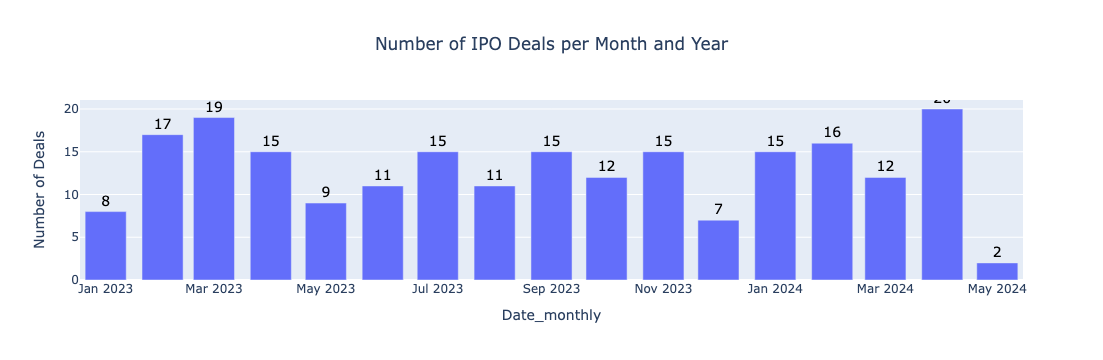

In [390]:
# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()

In [391]:
# To be used for home assignment: 'You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?
# Write down the answer X (a number between 1 and 30)

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
reddit = yf.download(tickers = "RDDT",
                     period = "max",
                     interval = "1d")

reddit.tail()

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2024-05-03  48.439999  48.700001  46.240002  46.639999  46.639999   1188300
2024-05-06  46.990002  49.869999  46.750000  48.270000  48.270000   2116700
2024-05-07  47.730000  50.330002  47.400002  49.400002  49.400002   6241700
2024-05-08  55.000000  55.160000  49.700001  51.400002  51.400002  13491500
2024-05-09  51.240002  51.099998  48.250000  49.810001  49.810001   2054203

<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

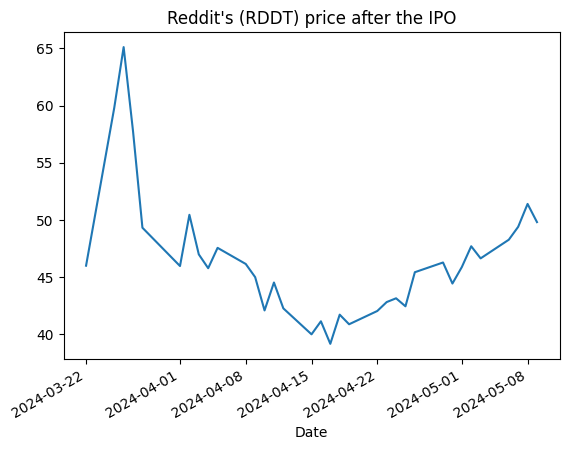

In [392]:
reddit['Adj Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')

#2) OHLCV data transformations

## 2.1 [Code Snippet 2] Time series for OHLCV

In [393]:
nvo_df = yf.download(tickers = "NVO",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [394]:
# big plus of an API's data: good typing from the box!
# notice DatetimeIndex - it is a recognised date
nvo_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10848 entries, 1981-04-30 to 2024-05-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10848 non-null  float64
 1   High       10848 non-null  float64
 2   Low        10848 non-null  float64
 3   Close      10848 non-null  float64
 4   Adj Close  10848 non-null  float64
 5   Volume     10848 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 593.2 KB


In [395]:
nvo_df.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-05-03  122.919998  123.769997  121.290001  123.050003  123.050003   
2024-05-06  122.000000  124.639999  121.779999  124.589996  124.589996   
2024-05-07  126.650002  127.800003  126.379997  127.290001  127.290001   
2024-05-08  127.510002  128.429993  126.620003  126.690002  126.690002   
2024-05-09  127.440002  128.110001  126.940002  127.830002  127.830002   

             Volume  
Date                 
2024-05-03  5932900  
2024-05-06  3636600  
2024-05-07  4167500  
2024-05-08  4059000  
2024-05-09   717109

In [396]:
# filter on date (index)
nvo_df_filtered_from_2020 = nvo_df[nvo_df.index>='2020-01-01']
nvo_df_filtered_from_2024 = nvo_df[nvo_df.index>='2024-01-01']

<Axes: title={'center': 'Novo Nordisk A/S (NVO) price daily'}, xlabel='Date'>

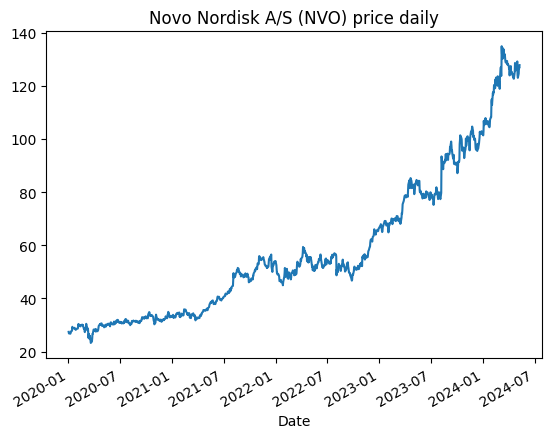

In [397]:
# Chaining: select one column, draw a plot, of a type line
nvo_df_filtered_from_2020['Adj Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily')

In [398]:
# generating new fields (using DateTime features):

nvo_df['Ticker'] = 'NVO'
nvo_df['Year']= nvo_df.index.year
nvo_df['Month'] = nvo_df.index.month
nvo_df['Weekday'] = nvo_df.index.weekday
nvo_df['Date'] = nvo_df.index.date # to be used in joins

In [399]:
nvo_df.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-05-03  122.919998  123.769997  121.290001  123.050003  123.050003   
2024-05-06  122.000000  124.639999  121.779999  124.589996  124.589996   
2024-05-07  126.650002  127.800003  126.379997  127.290001  127.290001   
2024-05-08  127.510002  128.429993  126.620003  126.690002  126.690002   
2024-05-09  127.440002  128.110001  126.940002  127.830002  127.830002   

             Volume Ticker  Year  Month  Weekday        Date  
Date                                                          
2024-05-03  5932900    NVO  2024      5        4  2024-05-03  
2024-05-06  3636600    NVO  2024      5        0  2024-05-06  
2024-05-07  4167500    NVO  2024      5        1  2024-05-07  
2024-05-08  4059000    NVO  2024      5        2  2024-05-08  
2024-05-09   717109    NVO  2024      5        3  2024-05-09

In [400]:
# shift ALL values (on x periods forward (+1) and backward (-1))
# equivalent of joining with a dataframe of the same vector, but with shifted date index
nvo_df['adj_close_minus_1'] = nvo_df['Adj Close'].shift(-1)
nvo_df['adj_close_plus_1'] = nvo_df['Adj Close'].shift(1)

nvo_df.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-05-03  122.919998  123.769997  121.290001  123.050003  123.050003   
2024-05-06  122.000000  124.639999  121.779999  124.589996  124.589996   
2024-05-07  126.650002  127.800003  126.379997  127.290001  127.290001   
2024-05-08  127.510002  128.429993  126.620003  126.690002  126.690002   
2024-05-09  127.440002  128.110001  126.940002  127.830002  127.830002   

             Volume Ticker  Year  Month  Weekday        Date  \
Date                                                           
2024-05-03  5932900    NVO  2024      5        4  2024-05-03   
2024-05-06  3636600    NVO  2024      5        0  2024-05-06   
2024-05-07  4167500    NVO  2024      5        1  2024-05-07   
2024-05-08  4059000    NVO  2024      5        2  2024-05-08   
2024-05-09   717109    NVO  2024      5        3  2024-05-09   

            adj_close_minus_1  adj_close_plus_1  
Date                                             
2024-05-03         124.589996        124.019997  
2024-05-06         127.290001        123.050003  
2024-05-07         126.690002        124.589996  
2024-05-08         127.830002        127.290001  
2024-05-09                NaN        126.690002

In [401]:
# historical growth
nvo_df['growth_1d'] = nvo_df['Adj Close'] / nvo_df['Adj Close'].shift(1)           # nvo_df['adj_close_plus_1']
nvo_df['growth_30d'] = nvo_df['Adj Close'] / nvo_df['Adj Close'].shift(30)

# FUTURE Growth : for regression models
nvo_df['growth_future_1d'] = nvo_df['Adj Close'].shift(-1) / nvo_df['Adj Close']   # nvo_df['adj_close_minus_1']

# FUTURE Growth: for binary models
nvo_df['is_positive_growth_1d_future'] = np.where(nvo_df['growth_future_1d'] > 1, 1, 0)

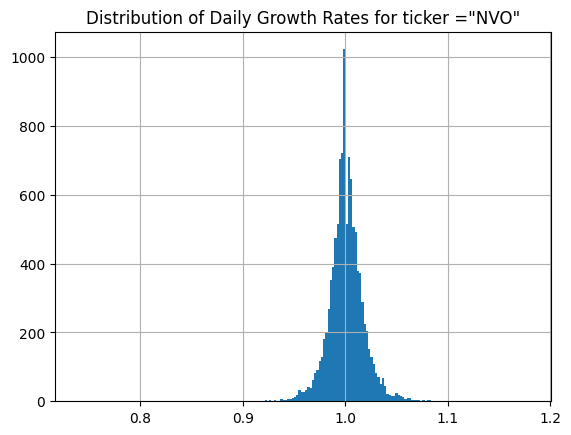

In [402]:
# normally the growth in 1 day is +-10%, while a lot of it is around 0% (around 1.)
plt.title('Distribution of Daily Growth Rates for ticker ="NVO"')
nvo_df.growth_1d.hist(bins=200)
plt.show()

<Axes: title={'center': 'Distribution of 2-days Growth Rates for ticker = "NVO"'}>

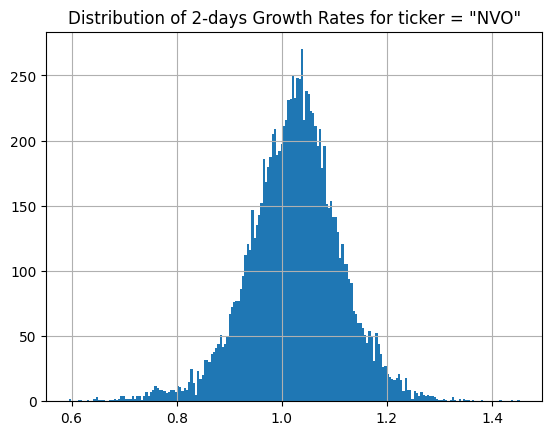

In [403]:
# you can see that the growth is can be much wider in 30 days (+- 30%)
plt.title('Distribution of 2-days Growth Rates for ticker = "NVO"')

nvo_df.growth_30d.hist(bins=200)

In [404]:
# for modeling: we use growth_1d, growth_2d as feature
COLUMNS = [k for k in nvo_df.keys() if k.find('growth')>=0 or k=='Adj Close']
nvo_df[COLUMNS].tail()

Adj Close  growth_1d  growth_30d  growth_future_1d  \
Date                                                              
2024-05-03  123.050003   0.992179    0.954616          1.012515   
2024-05-06  124.589996   1.012515    0.967614          1.021671   
2024-05-07  127.290001   1.021671    0.986362          0.995286   
2024-05-08  126.690002   0.995286    0.978982          1.008998   
2024-05-09  127.830002   1.008998    0.998282               NaN   

            is_positive_growth_1d_future  
Date                                      
2024-05-03                             1  
2024-05-06                             1  
2024-05-07                             0  
2024-05-08                             1  
2024-05-09                             0

In [405]:
# Calculate the distribution if future growth
nvo_df.is_positive_growth_1d_future.value_counts() / len(nvo_df)

is_positive_growth_1d_future
0    0.512813
1    0.487187
Name: count, dtype: float64

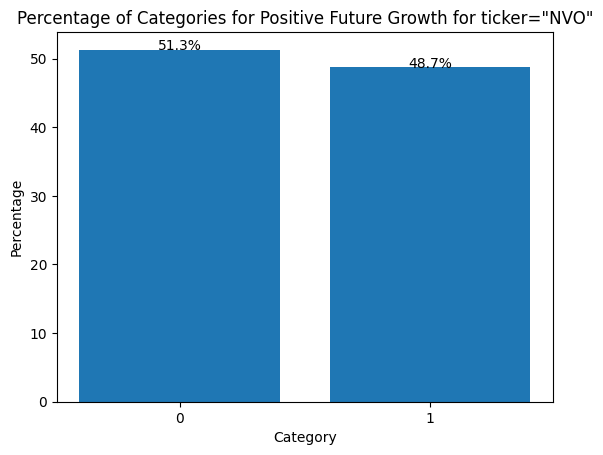

In [406]:
# Calculate value counts
value_counts = nvo_df['is_positive_growth_1d_future'].value_counts()

# Calculate percentage of each category
percentage = (value_counts / len(nvo_df)) * 100

# Plot as a bar chart
plt.bar(percentage.index.astype(str), percentage)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of Categories for Positive Future Growth for ticker="NVO"')

# Add percentage values on top of each bar
for i, value in enumerate(percentage):
    plt.text(i, value + 0, f'{value:.1f}%', ha='center')

plt.show()

## 2.2) [Code Snippet 6] Candlestick chart for OHLCV

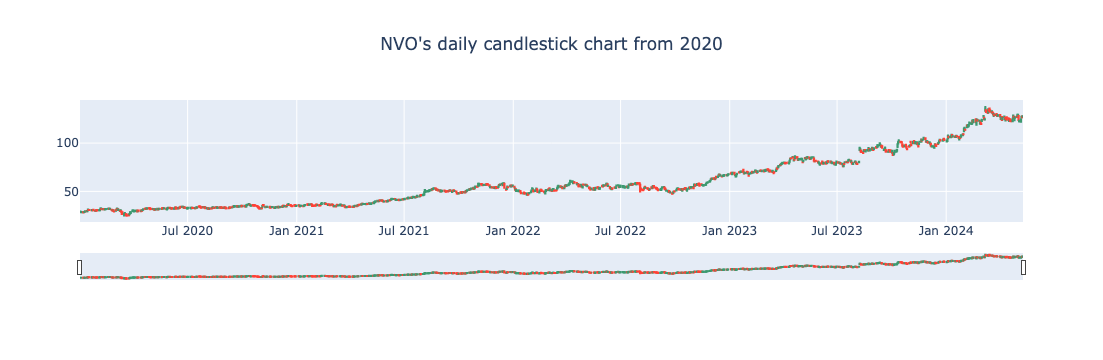

In [407]:
# Candlestick charts : https://plotly.com/python/candlestick-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2020.index,
                open=nvo_df_filtered_from_2020.Open,
                high=nvo_df_filtered_from_2020.High,
                low=nvo_df_filtered_from_2020.Low,
                close=nvo_df_filtered_from_2020.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2020",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

# 3) Macro Indicators

## 3.0) Previous indicators from module 1

In [408]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2024; month= 5; day=9
Period for indexes: 1954-05-09 to 2024-05-09 


In [409]:
# reuse code for ealier covered indicators
dax_daily = yf.download(tickers = "^GDAXI",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [410]:
for i in [1,3,7,30,90,365]:
  #DEBUG: dax_daily['Adj Close_sh_m_'+str(i)+'d'] = dax_daily['Adj Close'].shift(i)
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Adj Close'] / dax_daily['Adj Close'].shift(i)

In [411]:
dax_daily.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
1987-12-30  1005.190002  1005.190002  1005.190002  1005.190002  1005.190002   
1988-01-04   956.489990   956.489990   956.489990   956.489990   956.489990   
1988-01-05   996.099976   996.099976   996.099976   996.099976   996.099976   
1988-01-06  1006.010010  1006.010010  1006.010010  1006.010010  1006.010010   
1988-01-07  1014.469971  1014.469971  1014.469971  1014.469971  1014.469971   

            Volume  growth_dax_1d  growth_dax_3d  growth_dax_7d  \
Date                                                              
1987-12-30       0            NaN            NaN            NaN   
1988-01-04       0       0.951551            NaN            NaN   
1988-01-05       0       1.041412            NaN            NaN   
1988-01-06       0       1.009949       1.000816            NaN   
1988-01-07       0       1.008409       1.060617            NaN   

            growth_dax_30d  growth_dax_90d  growth_dax_365d  
Date                                                         
1987-12-30             NaN             NaN              NaN  
1988-01-04             NaN             NaN              NaN  
1988-01-05             NaN             NaN              NaN  
1988-01-06             NaN             NaN              NaN  
1988-01-07             NaN             NaN              NaN

In [412]:
dax_daily.tail(2)

Open          High           Low         Close  \
Date                                                                 
2024-05-08  18430.250000  18542.099609  18427.259766  18498.380859   
2024-05-09  18498.089844  18699.289062  18488.039062  18693.849609   

               Adj Close    Volume  growth_dax_1d  growth_dax_3d  \
Date                                                               
2024-05-08  18498.380859  74222500       1.003708       1.027597   
2024-05-09  18693.849609         0       1.010567       1.028535   

            growth_dax_7d  growth_dax_30d  growth_dax_90d  growth_dax_365d  
Date                                                                        
2024-05-08       1.018577        1.016063        1.107585         1.284874  
2024-05-09       1.031765        1.023686        1.115941         1.290094

In [413]:
GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]
dax_daily_to_merge.tail(1)

growth_dax_1d  growth_dax_3d  growth_dax_7d  growth_dax_30d  \
Date                                                                      
2024-05-09       1.010567       1.028535       1.031765        1.023686   

            growth_dax_90d  growth_dax_365d  
Date                                         
2024-05-09        1.115941         1.290094

In [414]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Adj Close'] / df['Adj Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [415]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
snp500_daily = yf.download(tickers = "^GSPC",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [416]:
snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail(2)

growth_snp500_1d  growth_snp500_3d  growth_snp500_7d  \
Date                                                               
2024-05-08          0.999994          1.011678          1.013975   
2024-05-09          1.003583          1.004926          1.033872   

            growth_snp500_30d  growth_snp500_90d  growth_snp500_365d  
Date                                                                  
2024-05-08           0.996942           1.084526            1.295758  
2024-05-09           0.991954           1.091498            1.292755

In [417]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch
dji_daily = yf.download(tickers = "^DJI",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [418]:
dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail(2)

growth_dji_1d  growth_dji_3d  growth_dji_7d  growth_dji_30d  \
Date                                                                      
2024-05-07       1.000823       1.017229       1.016857        0.989078   
2024-05-08       1.004427       1.009844       1.017462        0.994248   

            growth_dji_90d  growth_dji_365d  
Date                                         
2024-05-07        1.032604         1.153826  
2024-05-08        1.035701         1.145412

In [419]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI
epi_etf_daily = yf.download(tickers = "EPI",
                     period = "max",
                     interval = "1d")
epi_etf_daily.tail(2)

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2024-05-08  44.459999  44.660000  44.450001  44.549999  44.549999  1440300
2024-05-09  44.049999  44.119999  43.970001  44.099998  44.099998   362947

In [420]:
epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail(2)

growth_epi_1d  growth_epi_3d  growth_epi_7d  growth_epi_30d  \
Date                                                                      
2024-05-08       1.002927       0.977831       0.980198        1.038704   
2024-05-09       0.989899       0.979565       0.976528        1.021779   

            growth_epi_90d  growth_epi_365d  
Date                                         
2024-05-08        1.079738         1.359388  
2024-05-09        1.075610         1.346888

In [421]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot.tail(2)

GDPPOT  gdppot_us_yoy  gdppot_us_qoq
DATE                                              
2024-01-01  22618.15       0.022251       0.005466
2024-04-01  22739.00       0.022151       0.005343

In [422]:
gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail(1)

gdppot_us_yoy  gdppot_us_qoq
DATE                                    
2024-04-01       0.022151       0.005343

In [423]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl.tail(2)

CPILFESL  cpi_core_yoy  cpi_core_mom
DATE                                            
2024-02-01   315.565      0.037620      0.003584
2024-03-01   316.698      0.037973      0.003590

In [424]:
cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail(2)

cpi_core_yoy  cpi_core_mom
DATE                                  
2024-02-01      0.037620      0.003584
2024-03-01      0.037973      0.003590

In [425]:
# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail(2)

FEDFUNDS
DATE                
2024-03-01      5.33
2024-04-01      5.33

In [426]:
# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail(2)

DGS1
DATE            
2024-05-06  5.12
2024-05-07  5.13

In [427]:
# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail(2)

DGS5
DATE            
2024-05-06  4.48
2024-05-07  4.48

In [428]:
# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail(2)

DGS10
DATE             
2024-05-06   4.49
2024-05-07   4.47

## 3.1) [Code snippet 3] VIX - Volatility Index

In [429]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/
vix = yf.download(tickers = "^VIX",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [430]:
vix.tail(2)

Open   High    Low  Close  Adj Close  Volume
Date                                                     
2024-05-08  13.24  13.51  12.94  13.00      13.00       0
2024-05-09  13.08  13.29  13.07  13.09      13.09       0

In [431]:
vix_to_merge = vix['Adj Close']
vix_to_merge.tail()

Date
2024-05-03    13.49
2024-05-06    13.49
2024-05-07    13.23
2024-05-08    13.00
2024-05-09    13.09
Name: Adj Close, dtype: float64

<Axes: title={'center': 'VIX value over time'}, xlabel='Date'>

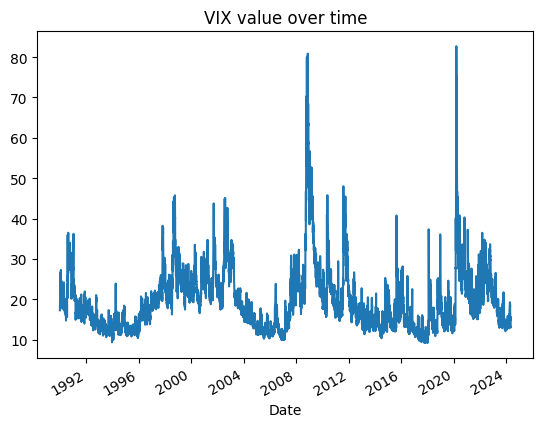

In [432]:
# Static graphs: hard to zoom in and get the exact dates of spikes
vix['Adj Close'].plot.line(title = "VIX value over time")

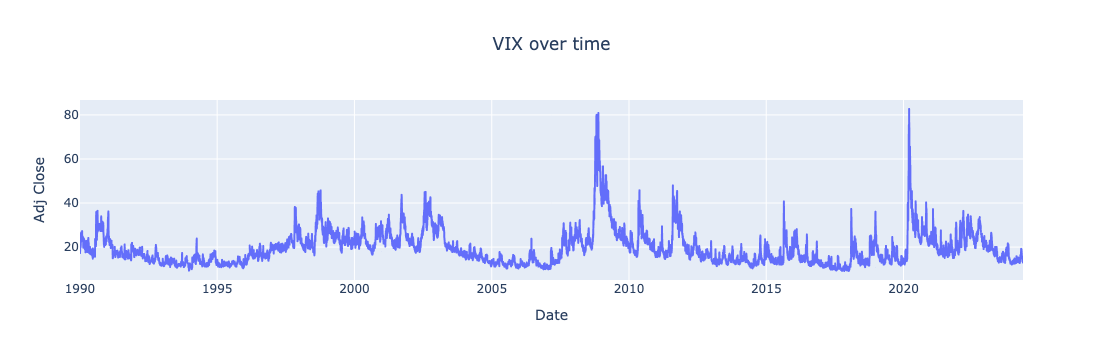

In [433]:
# Dynamic visualisation of VIX prices
fig = px.line(vix,
              x=vix.index,
              y="Adj Close",
              title='VIX over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.2) Gold - other assets

In [434]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF
gold = yf.download(tickers = "GC=F",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [435]:
gold.tail(1)

Open         High          Low        Close    Adj Close  Volume
Date                                                                          
2024-05-09  2316.5  2345.800049  2312.899902  2344.100098  2344.100098  173891

In [436]:
gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail(2)

growth_gold_1d  growth_gold_3d  growth_gold_7d  growth_gold_30d  \
Date                                                                          
2024-05-08        0.999309        1.006351        0.986442         1.063431   
2024-05-09        1.013183        1.009692        1.022999         1.070072   

            growth_gold_90d  growth_gold_365d  
Date                                           
2024-05-08         1.115579          1.325921  
2024-05-09         1.136589          1.336965

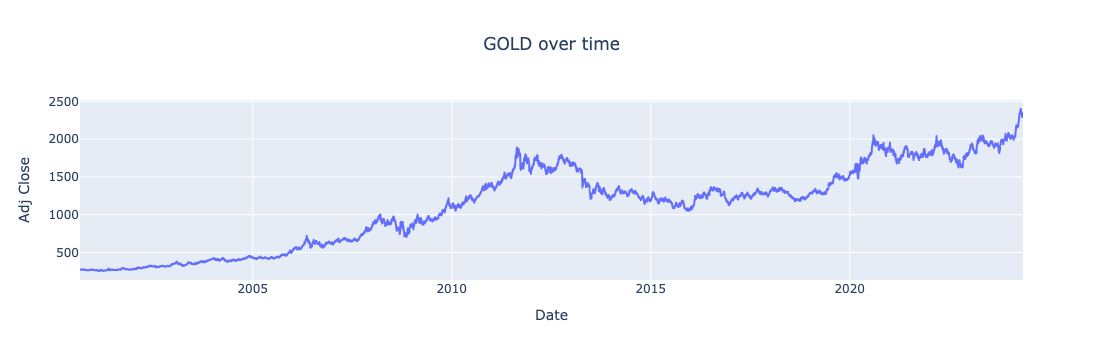

In [437]:
# Dynamic visualisation of GOLD prices
fig = px.line(gold,
              x=gold.index,
              y="Adj Close",
              title='GOLD over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.3) WTI Crude and Brent Oil

In [438]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/
crude_oil = yf.download(tickers = "CL=F",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [439]:
crude_oil.tail(2)

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2024-05-08  78.339996  79.269997  76.889999  78.989998  78.989998  327593
2024-05-09  79.230003  79.800003  78.919998  79.440002  79.440002  151009

In [440]:
crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail(2)

growth_wti_oil_1d  growth_wti_oil_3d  growth_wti_oil_7d  \
Date                                                                  
2024-05-08           1.007783           1.011266           0.955948   
2024-05-09           1.005697           1.012232           0.969608   

            growth_wti_oil_30d  growth_wti_oil_90d  growth_wti_oil_365d  
Date                                                                     
2024-05-08            0.967777            1.100599             1.013472  
2024-05-09            0.976521            1.108723             1.041426

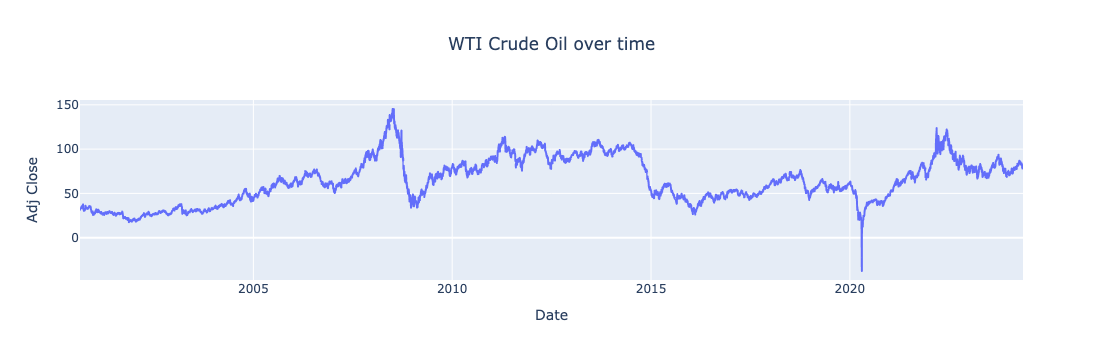

In [441]:
# Dynamic visualisation
fig = px.line(crude_oil,
              x=crude_oil.index,
              y="Adj Close",
              title='WTI Crude Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [442]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/
brent_oil = yf.download(tickers = "BZ=F",
                     period = "max",
                     interval = "1d")

brent_oil.tail(2)

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2024-05-08  83.040001  83.820000  81.720001  83.580002  83.580002   33414
2024-05-09  83.779999  84.330002  83.510002  83.989998  83.989998   15313

In [443]:
brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail(2)

growth_brent_oil_1d  growth_brent_oil_3d  growth_brent_oil_7d  \
Date                                                                        
2024-05-08             1.005050             1.007474             0.945475   
2024-05-09             1.004905             1.007920             0.955953   

            growth_brent_oil_30d  growth_brent_oil_90d  growth_brent_oil_365d  
Date                                                                           
2024-05-08              0.969043              1.066207               0.978574  
2024-05-09              0.975607              1.090213               1.004305

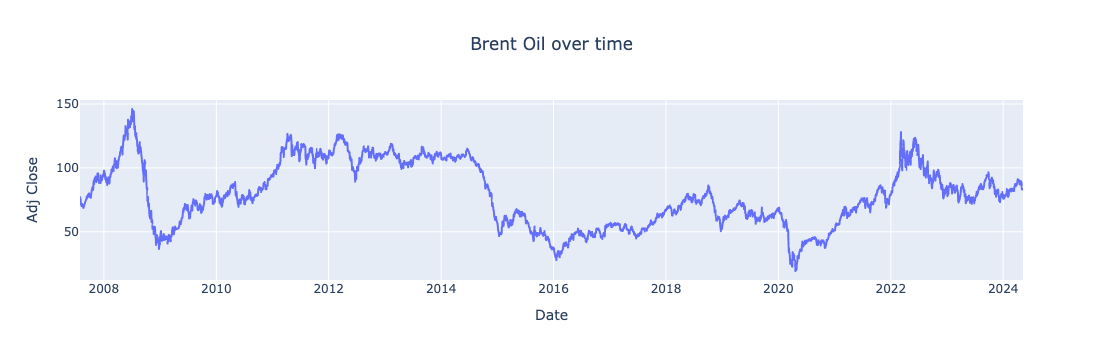

In [444]:
# Dynamic visualisation
fig = px.line(brent_oil,
              x=brent_oil.index,
              y="Adj Close",
              title='Brent Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.4) Bitcoin prices: BTC_USD

In [445]:
# https://finance.yahoo.com/quote/BTC-USD/
btc_usd =  yf.download(tickers = "BTC-USD",
                     period = "max",
                     interval = "1d")

btc_usd.tail(2)

[*********************100%%**********************]  1 of 1 completed


Open          High           Low         Close  \
Date                                                                 
2024-05-08  62332.640625  62986.085938  60877.128906  61187.941406   
2024-05-09  61171.207031  61863.828125  60719.507812  61698.519531   

               Adj Close       Volume  
Date                                   
2024-05-08  61187.941406  26088172222  
2024-05-09  61698.519531  24615028736

In [446]:
btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail(2)

growth_btc_usd_1d  growth_btc_usd_3d  growth_btc_usd_7d  \
Date                                                                  
2024-05-08           0.981601           0.955597           1.050364   
2024-05-09           1.008344           0.976831           1.043554   

            growth_btc_usd_30d  growth_btc_usd_90d  growth_btc_usd_365d  
Date                                                                     
2024-05-08            0.854206            1.350680             2.212243  
2024-05-09            0.892384            1.308636             2.233693

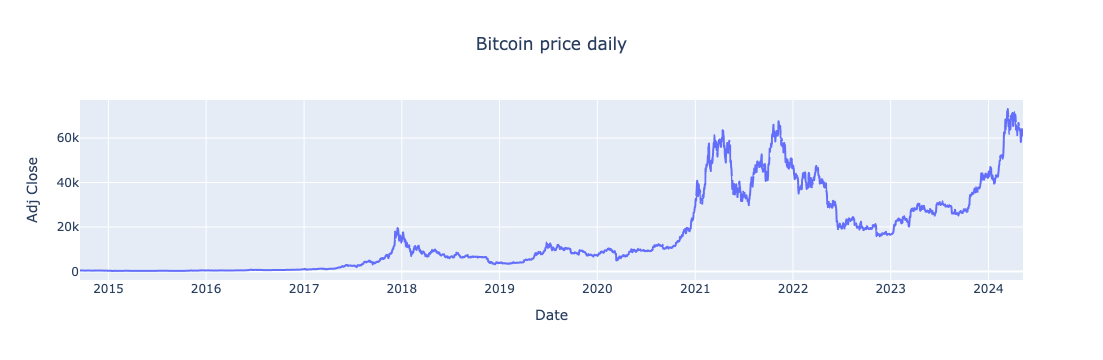

In [447]:
# Dynamic visualisation
fig = px.line(btc_usd,
              x=btc_usd.index,
              y="Adj Close",
              title='Bitcoin price daily')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.5 [Code snippet 4] Eurostat: "The home of high-quality statistics and data on Europe"


In [448]:
!pip install eurostat

# https://pypi.org/project/eurostat/
# https://ec.europa.eu/eurostat/web/main/data/database

In [449]:
# LONG WAIT TIME ~15 min, unless you filter data

# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
  # Euro yield curves (irt_euryld)
  # Reference Metadata in Euro SDMX Metadata Structure (ESMS)
  # Compiling agency: Eurostat, the statistical office of the European Uni

# the service is slow, you need to specify addtional params : https://pypi.org/project/eurostat/0.2.3/

filter_pars = {'startPeriod':'2024-04-01', 'endPeriod':'2024-05-01'}

code = 'irt_euryld_d'
eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [450]:
eurostat_euro_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freq              2148 non-null   object 
 1   yld_curv          2148 non-null   object 
 2   maturity          2148 non-null   object 
 3   bonds             2148 non-null   object 
 4   geo\TIME_PERIOD   2148 non-null   object 
 5   2024-04-02_value  2148 non-null   float64
 6   2024-04-02_flag   2148 non-null   object 
 7   2024-04-03_value  2148 non-null   float64
 8   2024-04-03_flag   2148 non-null   object 
 9   2024-04-04_value  2148 non-null   float64
 10  2024-04-04_flag   2148 non-null   object 
 11  2024-04-05_value  2148 non-null   float64
 12  2024-04-05_flag   2148 non-null   object 
 13  2024-04-08_value  2148 non-null   float64
 14  2024-04-08_flag   2148 non-null   object 
 15  2024-04-09_value  2148 non-null   float64
 16  2024-04-09_flag   2148 non-null   object 


In [451]:
eurostat_euro_yield_df.head()

freq yld_curv maturity       bonds geo\TIME_PERIOD  2024-04-02_value  \
0    D  INS_FWD      M10      CGB_EA              EA           2.93540   
1    D  INS_FWD      M10  CGB_EA_AAA              EA           2.84475   
2    D  INS_FWD      M11      CGB_EA              EA           2.87170   
3    D  INS_FWD      M11  CGB_EA_AAA              EA           2.76744   
4    D  INS_FWD       M3      CGB_EA              EA           3.61646   

  2024-04-02_flag  2024-04-03_value 2024-04-03_flag  2024-04-04_value  ...  \
0                           2.97183                           2.92502  ...   
1                           2.86360                           2.83422  ...   
2                           2.90848                           2.85814  ...   
3                           2.78547                           2.75286  ...   
4                           3.63975                           3.62033  ...   

  2024-04-23_value  2024-04-23_flag 2024-04-24_value  2024-04-24_flag  \
0          3.02264                           3.08430                    
1          2.91176                           2.96612                    
2          2.96704                           3.03342                    
3          2.84353                           2.90169                    
4          3.59855                           3.61313                    

  2024-04-25_value  2024-04-25_flag 2024-04-26_value  2024-04-26_flag  \
0          3.13182                           3.08867                    
1          3.01979                           2.98661                    
2          3.08275                           3.03647                    
3          2.95777                           2.92274                    
4          3.64745                           3.63097                    

  2024-04-29_value  2024-04-29_flag  
0          3.06128                   
1          2.95786                   
2          3.00758                   
3          2.89261                   
4          3.61332                   

[5 rows x 45 columns]

In [452]:
eurostat_euro_yield_df['bonds'].value_counts()

bonds
CGB_EA        1074
CGB_EA_AAA    1074
Name: count, dtype: int64

In [453]:
eurostat_euro_yield_df['maturity'].value_counts()


maturity
M10       6
Y26_M8    6
Y28_M4    6
Y28_M3    6
Y28_M2    6
         ..
Y18_M9    6
Y18_M8    6
Y18_M7    6
Y18_M6    6
Y9_M9     6
Name: count, Length: 358, dtype: int64

In [454]:
eurostat_euro_yield_df['yld_curv'].value_counts()

yld_curv
INS_FWD    716
PAR        716
SPOT_RT    716
Name: count, dtype: int64

In [455]:
eurostat_euro_yield_df

freq yld_curv maturity       bonds geo\TIME_PERIOD  2024-04-02_value  \
0       D  INS_FWD      M10      CGB_EA              EA           2.93540   
1       D  INS_FWD      M10  CGB_EA_AAA              EA           2.84475   
2       D  INS_FWD      M11      CGB_EA              EA           2.87170   
3       D  INS_FWD      M11  CGB_EA_AAA              EA           2.76744   
4       D  INS_FWD       M3      CGB_EA              EA           3.61646   
...   ...      ...      ...         ...             ...               ...   
2143    D  SPOT_RT    Y9_M7  CGB_EA_AAA              EA           2.46991   
2144    D  SPOT_RT    Y9_M8      CGB_EA              EA           3.05403   
2145    D  SPOT_RT    Y9_M8  CGB_EA_AAA              EA           2.47321   
2146    D  SPOT_RT    Y9_M9      CGB_EA              EA           3.05847   
2147    D  SPOT_RT    Y9_M9  CGB_EA_AAA              EA           2.47652   

     2024-04-02_flag  2024-04-03_value 2024-04-03_flag  2024-04-04_value  ...  \
0                              2.97183                           2.92502  ...   
1                              2.86360                           2.83422  ...   
2                              2.90848                           2.85814  ...   
3                              2.78547                           2.75286  ...   
4                              3.63975                           3.62033  ...   
...              ...               ...             ...               ...  ...   
2143                           2.46791                           2.39559  ...   
2144                           3.06662                           2.97186  ...   
2145                           2.47116                           2.39873  ...   
2146                           3.07104                           2.97618  ...   
2147                           2.47441                           2.40187  ...   

     2024-04-23_value  2024-04-23_flag 2024-04-24_value  2024-04-24_flag  \
0             3.02264                           3.08430                    
1             2.91176                           2.96612                    
2             2.96704                           3.03342                    
3             2.84353                           2.90169                    
4             3.59855                           3.61313                    
...               ...              ...              ...              ...   
2143          2.54635                           2.62834                    
2144          3.07345                           3.16620                    
2145          2.54935                           2.63147                    
2146          3.07734                           3.17017                    
2147          2.55236                           2.63460                    

     2024-04-25_value  2024-04-25_flag 2024-04-26_value  2024-04-26_flag  \
0             3.13182                           3.08867                    
1             3.01979                           2.98661                    
2             3.08275                           3.03647                    
3             2.95777                           2.92274                    
4             3.64745                           3.63097                    
...               ...              ...              ...              ...   
2143          2.68168                           2.60908                    
2144          3.23291                           3.14712                    
2145          2.68473                           2.61196                    
2146          3.23687                           3.15093                    
2147          2.68777                           2.61483                    

     2024-04-29_value  2024-04-29_flag  
0             3.06128                   
1             2.95786                   
2             3.00758                   
3             2.89261                   
4             3.61332                   
...               ...              

In [456]:
# Visual graph: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]

In [457]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2024-04-18_value']].head(20)

maturity  2024-04-18_value
1433      M10           3.36335
1435      M11           3.31940
1437       M3           3.72264
1439       M4           3.66536
1441       M5           3.61017
1443       M6           3.55700
1445       M7           3.50580
1447       M8           3.45649
1449       M9           3.40903
1451       Y1           3.27711
1453      Y10           2.55518
1455   Y10_M1           2.55824
1457  Y10_M10           2.58510
1459  Y10_M11           2.58800
1461   Y10_M2           2.56128
1463   Y10_M3           2.56431
1465   Y10_M4           2.56733
1467   Y10_M5           2.57033
1469   Y10_M6           2.57332
1471   Y10_M7           2.57629

In [458]:
def extract_numbers(input_string):
    y_match = re.search(r'Y(\d+)', input_string)
    m_match = re.search(r'M(\d+)', input_string)

    y_number = int(y_match.group(1)) if y_match else 0
    m_number = int(m_match.group(1)) if m_match else 0


    return y_number*12 + m_number

# Examples
examples = ["Y10_M2", "M3", "Y1"]
for example in examples:
    res = extract_numbers(example)
    print(f"{example} ==> {res}")

Y10_M2 ==> 122
M3 ==> 3
Y1 ==> 12


In [459]:
# define new field: "maturity in months"
filtered_eurostat_euro_yield_df['maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))

In [460]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2024-04-18_value']].head(20)

maturity  maturity_in_months  2024-04-18_value
1437       M3                   3           3.72264
1439       M4                   4           3.66536
1441       M5                   5           3.61017
1443       M6                   6           3.55700
1445       M7                   7           3.50580
1447       M8                   8           3.45649
1449       M9                   9           3.40903
1433      M10                  10           3.36335
1435      M11                  11           3.31940
1451       Y1                  12           3.27711
1693    Y1_M1                  13           3.23645
1699    Y1_M2                  14           3.19736
1701    Y1_M3                  15           3.15978
1703    Y1_M4                  16           3.12368
1705    Y1_M5                  17           3.08900
1707    Y1_M6                  18           3.05569
1709    Y1_M7                  19           3.02372
1711    Y1_M8                  20           2.99303
1713    Y1_M9                  21           2.96360
1695   Y1_M10                  22           2.93538

In [461]:
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

<Axes: title={'center': 'AAA rated bonds spot yield curve'}, xlabel='maturity_in_years'>

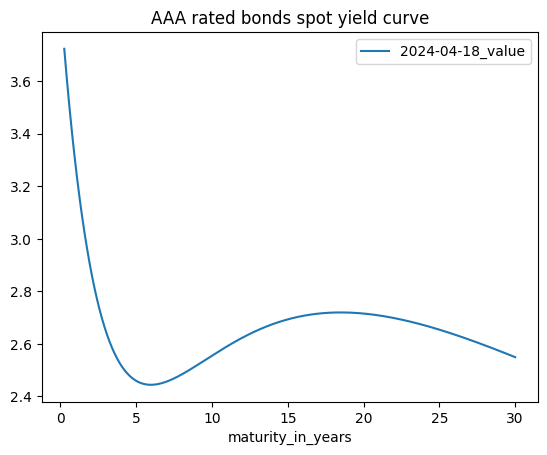

In [462]:
# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
filtered_eurostat_euro_yield_df \
  .sort_values(by='maturity_in_months')[['maturity_in_years','2024-04-18_value']] \
  .plot.line(x='maturity_in_years',
            y='2024-04-18_value',
            title='AAA rated bonds spot yield curve')

# 4) [Code Snippet 5] Fundamental indicators

* Read about "Ratio Analysis" to learn about more ratios: https://www.investopedia.com/terms/r/ratioanalysis.asp
* https://algotrading101.com/learn/yahoo-finance-api-guide/

In [463]:
# let's select some set of stocks: e.g. top US companies on 'Employees':
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/

US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

# WMT
ticker = US_TOP_EMPLOYEES_STOCKS[0]

# WMT ticker
one_company = yf.Ticker(ticker)

In [464]:
# Fundamental info appears close earning dates, you need to download it and use quickly (before/after trading day),
#  unless you're a fundamental long-term investor looking for a several months-quarters-years strategy (period between buy and sell)
# This dfthis is the easiest thing to join with the main dataset and get "some" technical indicators present
eps_earnings = one_company.earnings_dates
eps_earnings['Ticker'] = ticker
eps_earnings

EPS Estimate  Reported EPS  Surprise(%) Ticker
Earnings Date                                                            
2025-06-05 11:00:00-04:00          0.49           NaN          NaN    WMT
2025-02-20 08:00:00-05:00           NaN           NaN          NaN    WMT
2024-11-19 08:00:00-05:00           NaN           NaN          NaN    WMT
2024-08-15 08:00:00-04:00           NaN           NaN          NaN    WMT
2024-06-05 11:00:00-04:00          0.52           NaN          NaN    WMT
2024-05-16 08:00:00-04:00          0.52           NaN          NaN    WMT
2024-04-10 06:00:00-04:00          0.55           0.6       0.0909    WMT
2024-04-03 06:00:00-04:00          0.55           0.6       0.0909    WMT
2024-03-28 06:00:00-04:00          0.55           0.6       0.0909    WMT
2024-03-26 06:00:00-04:00          0.55           0.6       0.0909    WMT
2024-03-13 06:00:00-04:00          0.55           0.6       0.0909    WMT
2024-03-12 06:00:00-04:00          0.55           0.6       0.0909    WMT

In [465]:
one_company.calendar

{'Dividend Date': datetime.date(2025, 1, 6),
 'Ex-Dividend Date': datetime.date(2024, 5, 9),
 'Earnings Date': [datetime.date(2024, 5, 16)],
 'Earnings High': 0.55,
 'Earnings Low': 0.51,
 'Earnings Average': 0.52,
 'Revenue High': 160932000000,
 'Revenue Low': 157591000000,
 'Revenue Average': 159409000000}

In [466]:
one_company.financials

2024-01-31  \
Tax Effect Of Unusual Items                                    0.0   
Tax Rate For Calcs                                           0.255   
Normalized EBITDA                                    36384000000.0   
Total Unusual Items                                            0.0   
Total Unusual Items Excluding Goodwill                         0.0   
Net Income From Continuing Operation Net Minori...   15511000000.0   
Reconciled Depreciation                              11853000000.0   
Reconciled Cost Of Revenue                          490142000000.0   
EBITDA                                               36384000000.0   
EBIT                                                 24531000000.0   
Net Interest Income                                  -2137000000.0   
Interest Expense                                      2683000000.0   
Interest Income                                        546000000.0   
Normalized Income                                    15511000000.0   
Net Income From Continuing And Discontinued Ope...   15511000000.0   
Total Expenses                                      621113000000.0   
Total Operating Income As Reported                   27012000000.0   
Diluted Average Shares                                8108000000.0   
Basic Average Shares                                  8076999999.0   
Diluted EPS                                                   1.91   
Basic EPS                                                     1.92   
Diluted NI Availto Com Stockholders                  15511000000.0   
Net Income Common Stockholders                       15511000000.0   
Net Income                                           15511000000.0   
Minority Interests                                    -759000000.0   
Net Income Including Noncontrolling Interests        16270000000.0   
Net Income Continuous Operations                     16270000000.0   
Tax Provision                                         5578000000.0   
Pretax Income                                        21848000000.0   
Other Income Expense                                 -3027000000.0   
Other Non Operating Income Expenses                  -3027000000.0   
Special Income Charges                                         0.0   
Other Special Charges                                          NaN   
Net Non Operating Interest Income Expense            -2137000000.0   
Interest Expense Non Operating                        2683000000.0   
Interest Income Non Operating                          546000000.0   
Operating Income                                     27012000000.0   
Operating Expense                                   130971000000.0   
Selling General And Administration                  130971000000.0   
Gross Profit                                        157983000000.0   
Cost Of Revenue                                     490142000000.0   
Total Revenue                                       648125000000.0   
Operating Revenue                                   648125000000.0   

                                                        2023-01-31  \
Tax Effect Of Unusual Items                                    0.0   
Tax Rate For Calcs                                           0.336   
Normalized EBITDA                                    30089000000.0   
Total Unusual Items                                            0.0   
Total Unusual Items Excluding Goodwill                         0.0   
Net Income From Continuing Operation Net Minori...   11680000000.0   
Reconciled Depreciation                              10945000000.0   
Reconciled Cost Of Revenue                          463721000000.0   
EBITDA                                               30089000000.0   
EBIT                                                 19144000000.0   
Net Interest Income                                  -1874000000.0   
Interest Expense                                      2128000000.0   
Interest Income                                        254000000.

In [467]:
EPS = one_company.financials.loc['Basic EPS']
EPS

2024-01-31    1.92
2023-01-31    1.43
2022-01-31    1.63
2021-01-31    1.59
Name: Basic EPS, dtype: object

In [468]:
# or should we use NORMALIZED_EBITDA?
EBITDA = one_company.financials.loc['EBITDA']
EBITDA_margin = one_company.financials.loc['EBITDA'] /  one_company.financials.loc['Total Revenue']

In [469]:
EBITDA_margin

2024-01-31    0.056137
2023-01-31    0.049222
2022-01-31    0.054732
2021-01-31    0.060862
dtype: object

In [470]:
NET_INCOME = one_company.financials.loc['Net Income']
NET_INCOME_margin = one_company.financials.loc['Net Income'] /  one_company.financials.loc['Total Revenue']

In [471]:
NET_INCOME

2024-01-31    15511000000.0
2023-01-31    11680000000.0
2022-01-31    13673000000.0
2021-01-31    13510000000.0
Name: Net Income, dtype: object

In [472]:
# Compare with Public information - you can fully replicate the numbers (yearly and/or quarterly):
# https://www.wsj.com/market-data/quotes/WMT/financials/annual/income-statement
NET_INCOME_margin

2024-01-31    0.023932
2023-01-31    0.019107
2022-01-31    0.023872
2021-01-31    0.024162
dtype: object

In [473]:
# Combine the series into a DataFrame
df_fin_ratios = pd.DataFrame({
    'NET_INCOME_margin': 100.0 * NET_INCOME_margin, #for visualisation -- Margin in %
    'EBITDA_margin': 100.0 *EBITDA_margin, #for visualisation -- Margin in %
    'EPS': EPS
})

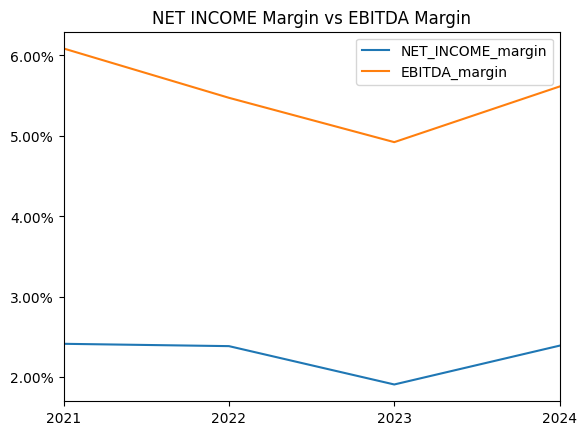

In [474]:
# Assuming df_fin_ratios is your DataFrame containing the financial ratios
# Make sure you have already created this DataFrame

# Plotting the specified columns
ax = df_fin_ratios[['NET_INCOME_margin','EBITDA_margin']].plot.line()

# Setting the y-axis formatter to display values as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title
plt.title('NET INCOME Margin vs EBITDA Margin')

# Displaying the plot
plt.show()

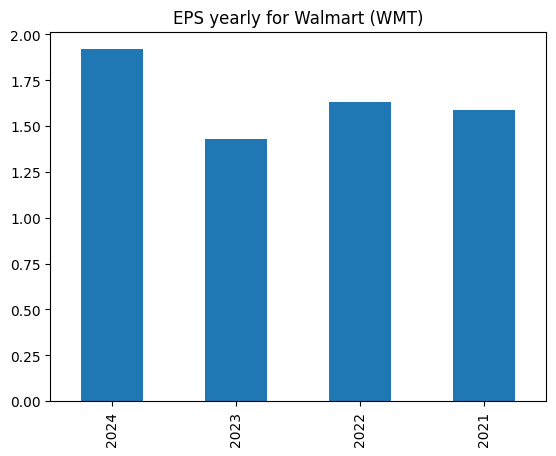

In [475]:
EPS_year = df_fin_ratios['EPS'].index.year

df_fin_ratios['EPS'].plot.bar(title = 'EPS yearly for Walmart (WMT)')

plt.xticks(range(len(EPS_year)), EPS_year)
# Displaying the plot
plt.show()

# 5) [Code snippet 7] Daily OHCLV data for a set of stocks

In [476]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

In [477]:
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS
ALL_TICKERS

['MSFT',
 'AAPL',
 'GOOG',
 'NVDA',
 'AMZN',
 'META',
 'BRK-B',
 'LLY',
 'AVGO',
 'V',
 'JPM',
 'NVO',
 'MC.PA',
 'ASML',
 'RMS.PA',
 'OR.PA',
 'SAP',
 'ACN',
 'TTE',
 'SIE.DE',
 'IDEXY',
 'CDI.PA',
 'RELIANCE.NS',
 'TCS.NS',
 'HDB',
 'BHARTIARTL.NS',
 'IBN',
 'SBIN.NS',
 'LICI.NS',
 'INFY',
 'ITC.NS',
 'HINDUNILVR.NS',
 'LT.NS']

In [478]:
stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  historyPrices = yf.download(tickers = ticker,
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Adj Close'] / historyPrices['Adj Close'].shift(i)
  historyPrices['growth_future_5d'] = historyPrices['Adj Close'].shift(-5) / historyPrices['Adj Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Adj Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Adj Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_5d_future'] = np.where(historyPrices['growth_future_5d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT


[*********************100%%**********************]  1 of 1 completed


1 AAPL


[*********************100%%**********************]  1 of 1 completed


2 GOOG


[*********************100%%**********************]  1 of 1 completed


3 NVDA


[*********************100%%**********************]  1 of 1 completed


4 AMZN


[*********************100%%**********************]  1 of 1 completed


5 META


[*********************100%%**********************]  1 of 1 completed


6 BRK-B


[*********************100%%**********************]  1 of 1 completed


7 LLY


[*********************100%%**********************]  1 of 1 completed


8 AVGO


[*********************100%%**********************]  1 of 1 completed


9 V


[*********************100%%**********************]  1 of 1 completed


10 JPM


[*********************100%%**********************]  1 of 1 completed


11 NVO


[*********************100%%**********************]  1 of 1 completed


12 MC.PA


[*********************100%%**********************]  1 of 1 completed


13 ASML


[*********************100%%**********************]  1 of 1 completed


14 RMS.PA


[*********************100%%**********************]  1 of 1 completed


15 OR.PA


[*********************100%%**********************]  1 of 1 completed


16 SAP


[*********************100%%**********************]  1 of 1 completed


17 ACN


[*********************100%%**********************]  1 of 1 completed


18 TTE


[*********************100%%**********************]  1 of 1 completed


19 SIE.DE


[*********************100%%**********************]  1 of 1 completed


20 IDEXY


[*********************100%%**********************]  1 of 1 completed


21 CDI.PA


[*********************100%%**********************]  1 of 1 completed


22 RELIANCE.NS


[*********************100%%**********************]  1 of 1 completed


23 TCS.NS


[*********************100%%**********************]  1 of 1 completed


24 HDB


[*********************100%%**********************]  1 of 1 completed


25 BHARTIARTL.NS


[*********************100%%**********************]  1 of 1 completed


26 IBN


[*********************100%%**********************]  1 of 1 completed


27 SBIN.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

28 LICI.NS


29 INFY


[*********************100%%**********************]  1 of 1 completed


30 ITC.NS


[*********************100%%**********************]  1 of 1 completed


31 HINDUNILVR.NS


[*********************100%%**********************]  1 of 1 completed


32 LT.NS


[*********************100%%**********************]  1 of 1 completed


In [479]:
def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'

In [480]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [481]:
# count of observations between US-EU-INDIA stocks
stocks_df.ticker_type.value_counts()

ticker_type
US       80750
EU       77091
INDIA    63367
Name: count, dtype: int64

In [482]:
# unique tickers
stocks_df.Ticker.nunique()

33

In [483]:
# count of observations by stock
stocks_df.Ticker.value_counts()

Ticker
LLY              13097
JPM              11131
AAPL             10943
NVO              10848
MSFT              9617
CDI.PA            8330
TTE               8195
ASML              7340
SAP               7211
HINDUNILVR.NS     7124
SBIN.NS           7122
RELIANCE.NS       7121
ITC.NS            7121
BRK-B             7048
SIE.DE            7048
AMZN              6791
NVDA              6366
INFY              6333
MC.PA             6260
RMS.PA            6260
OR.PA             6260
IBN               6068
ACN               5738
HDB               5737
LT.NS             5429
BHARTIARTL.NS     5426
TCS.NS            5397
GOOG              4965
V                 4064
AVGO              3715
IDEXY             3601
META              3013
LICI.NS            489
Name: count, dtype: int64

In [484]:
stocks_df.groupby(['Ticker','ticker_type']).Date.agg(['min','max'])

min         max
Ticker        ticker_type                        
AAPL          US           1980-12-12  2024-05-09
ACN           EU           2001-07-19  2024-05-09
AMZN          US           1997-05-15  2024-05-09
ASML          EU           1995-03-15  2024-05-09
AVGO          US           2009-08-06  2024-05-09
BHARTIARTL.NS INDIA        2002-07-01  2024-05-09
BRK-B         US           1996-05-09  2024-05-09
CDI.PA        EU           1992-01-27  2024-05-09
GOOG          US           2004-08-19  2024-05-09
HDB           INDIA        2001-07-20  2024-05-09
HINDUNILVR.NS INDIA        1996-01-01  2024-05-09
IBN           INDIA        2000-03-28  2024-05-09
IDEXY         EU           2010-01-20  2024-05-09
INFY          INDIA        1999-03-11  2024-05-09
ITC.NS        INDIA        1996-01-01  2024-05-09
JPM           US           1980-03-17  2024-05-09
LICI.NS       INDIA        2022-05-17  2024-05-09
LLY           US           1972-06-01  2024-05-09
LT.NS         INDIA        2002-07-01  2024-05-09
MC.PA         EU           2000-01-03  2024-05-09
META          US           2012-05-18  2024-05-09
MSFT          US           1986-03-13  2024-05-09
NVDA          US           1999-01-22  2024-05-09
NVO           EU           1981-04-30  2024-05-09
OR.PA         EU           2000-01-03  2024-05-09
RELIANCE.NS   INDIA        1996-01-01  2024-05-09
RMS.PA        EU           2000-01-03  2024-05-09
SAP           EU           1995-09-18  2024-05-09
SBIN.NS       INDIA        1996-01-01  2024-05-09
SIE.DE        EU           1996-11-08  2024-05-09
TCS.NS        INDIA        2002-08-12  2024-05-09
TTE           EU           1991-10-25  2024-05-09
V             US           2008-03-19  2024-05-09

In [485]:
#  average growth 365days
stocks_df[stocks_df.Year>=2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

Year  ticker_type
2020  EU             1.245388
      INDIA          1.101896
      US             1.484070
2021  EU             1.582170
      INDIA          1.546424
      US             1.797571
2022  EU             1.191169
      INDIA          1.379889
      US             1.182379
2023  EU             1.246533
      INDIA          1.201110
      US             1.203253
2024  EU             1.635082
      INDIA          1.300180
      US             2.165863
Name: growth_365d, dtype: float64

In [486]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [487]:
# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182741 entries, 3490 to 221207
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Open                          182741 non-null  float64       
 1   High                          182741 non-null  float64       
 2   Low                           182741 non-null  float64       
 3   Close                         182741 non-null  float64       
 4   Adj Close                     182741 non-null  float64       
 5   Volume                        182741 non-null  int64         
 6   Ticker                        182741 non-null  object        
 7   Year                          182741 non-null  int32         
 8   Month                         182741 non-null  int32         
 9   Weekday                       182741 non-null  int32         
 10  Date                          182741 non-null  datetime64[ns]
 11  growth_1d      

In [488]:
stocks_df[stocks_df.Date=='2024-04-01'].tail()

Open         High          Low        Close    Adj Close  \
195175   925.000000   984.450012   924.000000   970.599976   970.599976   
201505    17.889999    17.920000    17.500000    17.580000    17.580000   
208629   429.100006   431.350006   425.750000   426.700012   426.700012   
215753  2270.000000  2295.000000  2262.000000  2285.899902  2285.899902   
221182  3780.850098  3851.850098  3780.850098  3838.000000  3838.000000   

          Volume         Ticker  Year  Month  Weekday  ... growth_90d  \
195175   4863536        LICI.NS  2024      4        0  ...   1.599113   
201505  14601600           INFY  2024      4        0  ...   1.003998   
208629   9382308         ITC.NS  2024      4        0  ...   0.987044   
215753   1427873  HINDUNILVR.NS  2024      4        0  ...   0.917590   
221182   1905190          LT.NS  2024      4        0  ...   1.257886   

        growth_365d  growth_future_5d        SMA10        SMA20  \
195175     1.556710          1.026891   906.085004   953.950003   
201505     1.024508          1.015927    18.156000    18.777500   
208629     1.314436          1.005625   422.235004   416.537502   
215753     0.894050          0.992585  2266.539990  2327.240015   
221182     2.010850          0.992144  3626.594971  3618.109985   

        growing_moving_average  high_minus_low_relative   volatility  \
195175                       0                 0.062281  1034.237352   
201505                       0                 0.023891    13.940634   
208629                       1                 0.013124   130.246651   
215753                       0                 0.014436  1049.970071   
221182                       1                 0.018499  2188.619806   

        is_positive_growth_5d_future  ticker_type  
195175                             1        INDIA  
201505                             1        INDIA  
208629                             1        INDIA  
215753                             0        INDIA  
221182                             0        INDIA  

[5 rows x 25 columns]

#6) [Code Snippet 8] Technical Indicators with TA-lib
* PythonInvest article on Tech. Indicators
* Code for generating 100+ tech. indicators/patterns : https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part14_Exploring_Tech_Indicators_For_Stocks_and_Crypto.ipynb

Indicator groups: https://github.com/TA-Lib/ta-lib-python/blob/master/README.md

* Overlap Studies (17)
* Momentum Indicators (30+)
* Volume Indicators (3)
* Cycle Indicators (5)
* Price Transform (4)
* Volatility Indicators (3)
* Pattern Recognition (60)

In [489]:
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
# Update (apr 2023): Colab is now Python 3.10
# there are some other (older) ways to install talib

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4115    0  4115    0     0   5362      0 --:--:-- --:--:-- --:--:--  5358
 25  517k   25  131k    0     0  70812      0  0:00:07  0:00:01  0:00:06 70812tar: could not chdir to '/usr/lib/x86_64-linux-gnu/'

 60  517k   60  311k    0     0   148k      0  0:00:03  0:00:02  0:00:01  922k
curl: (23) Failure writing output to destination
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4115    0  4115    0     0   5468      0 --:--:-- --:--:-- --:--:--  5464
 82  392k   82  324k    0     0   125k      0  0:00:03  0:00:02  0:00:01  296ktar: could not chdir to '/usr/local/lib/python3.10/dist-packages/'

 86  392k   86  340k    0     0   120k      0  0:00:03  0:00:02  0:00:01  251k
curl: (23) Failure writing output to dest

## 6.1) Momentum indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/momentum_indicators.md

In [490]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index <dateTime, ticker>
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

## 6.2 Volume, Volatility, Cycle, Price indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md

In [491]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

## 6.3) Pattern indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md

In [492]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

## 6.4) Calculate Tech Indicators and Merge to the original dataframe

In [493]:
# Volume needs to be float, not int
stocks_df['Volume'] = stocks_df['Volume']*1.0

In [494]:
# to resolve an error "Exception: input array type is not double"
# https://stackoverflow.com/questions/51712269/how-to-run-ta-lib-on-multiple-columns-of-a-pandas-dataframe
for f in ['Open','High','Low','Close', 'Volume', 'Adj Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

In [495]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221208 entries, 0 to 221207
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Open                          221208 non-null  float64       
 1   High                          221208 non-null  float64       
 2   Low                           221208 non-null  float64       
 3   Close                         221208 non-null  float64       
 4   Adj Close                     221208 non-null  float64       
 5   Volume                        221208 non-null  float64       
 6   Ticker                        221208 non-null  object        
 7   Year                          221208 non-null  int32         
 8   Month                         221208 non-null  int32         
 9   Weekday                       221208 non-null  int32         
 10  Date                          221208 non-null  datetime64[ns]
 11  growth_1d    

In [496]:
import pandas as pd
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

1/33 Current ticker is MSFT
2/33 Current ticker is AAPL
3/33 Current ticker is GOOG
4/33 Current ticker is NVDA
5/33 Current ticker is AMZN
6/33 Current ticker is META
7/33 Current ticker is BRK-B
8/33 Current ticker is LLY
9/33 Current ticker is AVGO
10/33 Current ticker is V
11/33 Current ticker is JPM
12/33 Current ticker is NVO
13/33 Current ticker is MC.PA
14/33 Current ticker is ASML
15/33 Current ticker is RMS.PA
16/33 Current ticker is OR.PA
17/33 Current ticker is SAP
18/33 Current ticker is ACN
19/33 Current ticker is TTE
20/33 Current ticker is SIE.DE
21/33 Current ticker is IDEXY
22/33 Current ticker is CDI.PA
23/33 Current ticker is RELIANCE.NS
24/33 Current ticker is TCS.NS
25/33 Current ticker is HDB
26/33 Current ticker is BHARTIARTL.NS
27/33 Current ticker is IBN
28/33 Current ticker is SBIN.NS
29/33 Current ticker is LICI.NS
30/33 Current ticker is INFY
31/33 Current ticker is ITC.NS
32/33 Current ticker is HINDUNILVR.NS
33/33 Current ticker is LT.NS


In [497]:
merged_df_with_tech_ind[merged_df_with_tech_ind.Date=='2024-04-01'].tail()

Open         High          Low        Close    Adj Close  \
463    925.000000   984.450012   924.000000   970.599976   970.599976   
6304    17.889999    17.920000    17.500000    17.580000    17.580000   
7095   429.100006   431.350006   425.750000   426.700012   426.700012   
7098  2270.000000  2295.000000  2262.000000  2285.899902  2285.899902   
5403  3780.850098  3851.850098  3780.850098  3838.000000  3838.000000   

          Volume         Ticker  Year  Month  Weekday  ... cdlspinningtop  \
463    4863536.0        LICI.NS  2024      4        0  ...              0   
6304  14601600.0           INFY  2024      4        0  ...              0   
7095   9382308.0         ITC.NS  2024      4        0  ...              0   
7098   1427873.0  HINDUNILVR.NS  2024      4        0  ...              0   
5403   1905190.0          LT.NS  2024      4        0  ...              0   

      cdlstalledpattern  cdlsticksandwich  cdltakuru  cdltasukigap  \
463                   0                 0          0             0   
6304                  0                 0          0             0   
7095                  0                 0          0             0   
7098                  0                 0          0             0   
5403                  0                 0          0             0   

      cdlthrusting  cdltristar  cdlunique3river  cdlupsidegap2crows  \
463              0           0                0                   0   
6304             0           0                0                   0   
7095             0           0                0                   0   
7098             0           0                0                   0   
5403             0           0                0                   0   

      cdlxsidegap3methods  
463                     0  
6304                    0  
7095                    0  
7098                    0  
5403                    0  

[5 rows x 144 columns]

In [498]:
merged_df_with_tech_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221208 entries, 0 to 5428
Columns: 144 entries, Open to cdlxsidegap3methods
dtypes: datetime64[ns, UTC](1), float64(71), int32(65), int64(5), object(2)
memory usage: 189.9+ MB


# 7) [Code snippet 9] Merge All Together

In [499]:
merged_df_with_tech_ind.head(1)

Open      High       Low     Close  Adj Close        Volume Ticker  \
0  0.088542  0.101563  0.088542  0.097222   0.060163  1.031789e+09   MSFT   

   Year  Month  Weekday  ... cdlspinningtop  cdlstalledpattern  \
0  1986      3        3  ...              0                  0   

   cdlsticksandwich  cdltakuru  cdltasukigap  cdlthrusting  cdltristar  \
0                 0          0             0             0           0   

   cdlunique3river  cdlupsidegap2crows  cdlxsidegap3methods  
0                0                   0                    0  

[1 rows x 144 columns]

In [500]:
merged_df_with_tech_ind.shape

(221208, 144)

In [501]:
# make sure it is dateTime with no timezone
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)

In [502]:
# merge with dax_daily_to_merge
dax_daily_to_merge.tail(1)

growth_dax_1d  growth_dax_3d  growth_dax_7d  growth_dax_30d  \
Date                                                                      
2024-05-09       1.010567       1.028535       1.031765        1.023686   

            growth_dax_90d  growth_dax_365d  
Date                                         
2024-05-09        1.115941         1.290094

In [503]:
m2 = pd.merge(merged_df_with_tech_ind,
              dax_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [504]:
m2.tail(1)

Open    High          Low        Close    Adj Close      Volume  \
5428  3312.75  3377.0  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year  Month  Weekday  ... cdltristar  cdlunique3river  \
5428  LT.NS  2024      5        3  ...          0                0   

      cdlupsidegap2crows  cdlxsidegap3methods  growth_dax_1d  growth_dax_3d  \
5428                   0                    0       1.010567       1.028535   

      growth_dax_7d  growth_dax_30d  growth_dax_90d  growth_dax_365d  
5428       1.031765        1.023686        1.115941         1.290094  

[1 rows x 150 columns]

In [505]:
# check the same number of records, but columns increased
m2.shape

(221208, 150)

In [506]:
# merge with dax_daily_to_merge
snp500_to_merge.tail(1)

growth_snp500_1d  growth_snp500_3d  growth_snp500_7d  \
Date                                                               
2024-05-09          1.003583          1.004926          1.033872   

            growth_snp500_30d  growth_snp500_90d  growth_snp500_365d  
Date                                                                  
2024-05-09           0.991954           1.091498            1.292755

In [507]:
m3 = pd.merge(m2,
              snp500_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [508]:
m3.tail(1)

Open    High          Low        Close    Adj Close      Volume  \
5428  3312.75  3377.0  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year  Month  Weekday  ... growth_dax_7d  growth_dax_30d  \
5428  LT.NS  2024      5        3  ...      1.031765        1.023686   

      growth_dax_90d  growth_dax_365d  growth_snp500_1d  growth_snp500_3d  \
5428        1.115941         1.290094          1.003583          1.004926   

      growth_snp500_7d  growth_snp500_30d  growth_snp500_90d  \
5428          1.033872           0.991954           1.091498   

      growth_snp500_365d  
5428            1.292755  

[1 rows x 156 columns]

In [509]:
m3.shape

(221208, 156)

In [510]:
m4 = pd.merge(m3,
              dji_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [511]:
m4.shape

(221208, 162)

In [512]:
m4.tail(1)

Open    High          Low        Close    Adj Close      Volume  \
5428  3312.75  3377.0  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year  Month  Weekday  ... growth_snp500_7d  growth_snp500_30d  \
5428  LT.NS  2024      5        3  ...         1.033872           0.991954   

      growth_snp500_90d  growth_snp500_365d  growth_dji_1d  growth_dji_3d  \
5428           1.091498            1.292755            NaN            NaN   

      growth_dji_7d  growth_dji_30d  growth_dji_90d  growth_dji_365d  
5428            NaN             NaN             NaN              NaN  

[1 rows x 162 columns]

In [513]:
m5 = pd.merge(m4,
              epi_etf_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [514]:
m5.shape

(221208, 168)

In [515]:
# define quarter as the first date of qtr
m5['Quarter'] = m5['Date'].dt.to_period('Q').dt.to_timestamp()
m5['Quarter']

0      1986-01-01
1      1986-01-01
2      1986-01-01
3      1986-01-01
4      1986-01-01
          ...    
5424   2024-04-01
5425   2024-04-01
5426   2024-04-01
5427   2024-04-01
5428   2024-04-01
Name: Quarter, Length: 221208, dtype: datetime64[ns]

In [516]:
gdppot_to_merge.tail(1)

gdppot_us_yoy  gdppot_us_qoq
DATE                                    
2024-04-01       0.022151       0.005343

In [517]:
m6 = pd.merge(m5,
              gdppot_to_merge,
              how='left',
              left_on='Quarter',
              right_index=True,
              validate = "many_to_one"
              )

In [518]:
m6.tail(2)

Open         High          Low        Close    Adj Close      Volume  \
5427  3429.00  3497.399902  3367.800049  3486.850098  3486.850098   4116670.0   
5428  3312.75  3377.000000  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year  Month  Weekday  ... growth_dji_365d  growth_epi_1d  \
5427  LT.NS  2024      5        2  ...        1.145412       1.002927   
5428  LT.NS  2024      5        3  ...             NaN       0.989899   

      growth_epi_3d  growth_epi_7d  growth_epi_30d  growth_epi_90d  \
5427       0.977831       0.980198        1.038704        1.079738   
5428       0.979565       0.976528        1.021779        1.075610   

      growth_epi_365d    Quarter  gdppot_us_yoy  gdppot_us_qoq  
5427         1.359388 2024-04-01       0.022151       0.005343  
5428         1.346888 2024-04-01       0.022151       0.005343  

[2 rows x 171 columns]

In [519]:
m6.shape

(221208, 171)

In [520]:
m6['Month'] = m6['Date'].dt.to_period('M').dt.to_timestamp()
m6['Month']

0      1986-03-01
1      1986-03-01
2      1986-03-01
3      1986-03-01
4      1986-03-01
          ...    
5424   2024-05-01
5425   2024-05-01
5426   2024-05-01
5427   2024-05-01
5428   2024-05-01
Name: Month, Length: 221208, dtype: datetime64[ns]

In [521]:
cpilfesl_to_merge.tail(1)

cpi_core_yoy  cpi_core_mom
DATE                                  
2024-03-01      0.037973       0.00359

In [522]:
m7 = pd.merge(m6,
              cpilfesl_to_merge,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [523]:
# PROBLEM! Last month is not defined
m7.tail(1)

Open    High          Low        Close    Adj Close      Volume  \
5428  3312.75  3377.0  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_epi_3d  growth_epi_7d  \
5428  LT.NS  2024 2024-05-01        3  ...      0.979565       0.976528   

      growth_epi_30d  growth_epi_90d  growth_epi_365d    Quarter  \
5428        1.021779         1.07561         1.346888 2024-04-01   

      gdppot_us_yoy  gdppot_us_qoq  cpi_core_yoy  cpi_core_mom  
5428       0.022151       0.005343           NaN           NaN  

[1 rows x 173 columns]

In [524]:
fields_to_fill = ['cpi_core_yoy',	'cpi_core_mom']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m7[field] = m7[field].fillna(method='ffill')

/var/folders/9t/gnjff14n4zq228dml1fm7v_w0000gn/T/ipykernel_87445/3633826833.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [525]:
m7.tail(1)

Open    High          Low        Close    Adj Close      Volume  \
5428  3312.75  3377.0  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_epi_3d  growth_epi_7d  \
5428  LT.NS  2024 2024-05-01        3  ...      0.979565       0.976528   

      growth_epi_30d  growth_epi_90d  growth_epi_365d    Quarter  \
5428        1.021779         1.07561         1.346888 2024-04-01   

      gdppot_us_yoy  gdppot_us_qoq  cpi_core_yoy  cpi_core_mom  
5428       0.022151       0.005343      0.037973       0.00359  

[1 rows x 173 columns]

In [526]:
fedfunds.tail(1)

FEDFUNDS
DATE                
2024-04-01      5.33

In [527]:
m8 = pd.merge(m7,
              fedfunds,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [528]:
m8.tail(1)

Open    High          Low        Close    Adj Close      Volume  \
5428  3312.75  3377.0  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_epi_7d  growth_epi_30d  \
5428  LT.NS  2024 2024-05-01        3  ...      0.976528        1.021779   

      growth_epi_90d  growth_epi_365d    Quarter  gdppot_us_yoy  \
5428         1.07561         1.346888 2024-04-01       0.022151   

      gdppot_us_qoq  cpi_core_yoy  cpi_core_mom  FEDFUNDS  
5428       0.005343      0.037973       0.00359       NaN  

[1 rows x 174 columns]

In [529]:
fields_to_fill = ['FEDFUNDS']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m8[field] = m8[field].fillna(method='ffill')

/var/folders/9t/gnjff14n4zq228dml1fm7v_w0000gn/T/ipykernel_87445/520370561.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [530]:
m8.tail(1)

Open    High          Low        Close    Adj Close      Volume  \
5428  3312.75  3377.0  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_epi_7d  growth_epi_30d  \
5428  LT.NS  2024 2024-05-01        3  ...      0.976528        1.021779   

      growth_epi_90d  growth_epi_365d    Quarter  gdppot_us_yoy  \
5428         1.07561         1.346888 2024-04-01       0.022151   

      gdppot_us_qoq  cpi_core_yoy  cpi_core_mom  FEDFUNDS  
5428       0.005343      0.037973       0.00359      5.33  

[1 rows x 174 columns]

In [531]:
dgs1.tail(1)

DGS1
DATE            
2024-05-07  5.13

In [532]:
m9 = pd.merge(m8,
              dgs1,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [533]:
# fix last day later
m9.tail(2)

Open         High          Low        Close    Adj Close      Volume  \
5427  3429.00  3497.399902  3367.800049  3486.850098  3486.850098   4116670.0   
5428  3312.75  3377.000000  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_epi_30d  growth_epi_90d  \
5427  LT.NS  2024 2024-05-01        2  ...       1.038704        1.079738   
5428  LT.NS  2024 2024-05-01        3  ...       1.021779        1.075610   

      growth_epi_365d    Quarter  gdppot_us_yoy  gdppot_us_qoq  cpi_core_yoy  \
5427         1.359388 2024-04-01       0.022151       0.005343      0.037973   
5428         1.346888 2024-04-01       0.022151       0.005343      0.037973   

      cpi_core_mom  FEDFUNDS  DGS1  
5427       0.00359      5.33   NaN  
5428       0.00359      5.33   NaN  

[2 rows x 175 columns]

In [534]:
m10 = pd.merge(m9,
              dgs5,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [535]:
# fix last day later
m10.tail(2)

Open         High          Low        Close    Adj Close      Volume  \
5427  3429.00  3497.399902  3367.800049  3486.850098  3486.850098   4116670.0   
5428  3312.75  3377.000000  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_epi_90d  growth_epi_365d  \
5427  LT.NS  2024 2024-05-01        2  ...       1.079738         1.359388   
5428  LT.NS  2024 2024-05-01        3  ...       1.075610         1.346888   

        Quarter  gdppot_us_yoy  gdppot_us_qoq  cpi_core_yoy  cpi_core_mom  \
5427 2024-04-01       0.022151       0.005343      0.037973       0.00359   
5428 2024-04-01       0.022151       0.005343      0.037973       0.00359   

      FEDFUNDS  DGS1  DGS5  
5427      5.33   NaN   NaN  
5428      5.33   NaN   NaN  

[2 rows x 176 columns]

In [536]:
m11 = pd.merge(m10,
              dgs10,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [537]:
m11.tail(2)

Open         High          Low        Close    Adj Close      Volume  \
5427  3429.00  3497.399902  3367.800049  3486.850098  3486.850098   4116670.0   
5428  3312.75  3377.000000  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_epi_365d    Quarter  \
5427  LT.NS  2024 2024-05-01        2  ...        1.359388 2024-04-01   
5428  LT.NS  2024 2024-05-01        3  ...        1.346888 2024-04-01   

      gdppot_us_yoy  gdppot_us_qoq  cpi_core_yoy  cpi_core_mom  FEDFUNDS  \
5427       0.022151       0.005343      0.037973       0.00359      5.33   
5428       0.022151       0.005343      0.037973       0.00359      5.33   

      DGS1  DGS5  DGS10  
5427   NaN   NaN    NaN  
5428   NaN   NaN    NaN  

[2 rows x 177 columns]

In [538]:
vix_to_merge

Date
1990-01-02    17.240000
1990-01-03    18.190001
1990-01-04    19.219999
1990-01-05    20.110001
1990-01-08    20.260000
                ...    
2024-05-03    13.490000
2024-05-06    13.490000
2024-05-07    13.230000
2024-05-08    13.000000
2024-05-09    13.090000
Name: Adj Close, Length: 8655, dtype: float64

In [539]:
m12 = pd.merge(m11,
              vix_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [540]:
m12.tail(2)

Open         High          Low        Close  Adj Close_x      Volume  \
5427  3429.00  3497.399902  3367.800049  3486.850098  3486.850098   4116670.0   
5428  3312.75  3377.000000  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ...    Quarter  gdppot_us_yoy  \
5427  LT.NS  2024 2024-05-01        2  ... 2024-04-01       0.022151   
5428  LT.NS  2024 2024-05-01        3  ... 2024-04-01       0.022151   

      gdppot_us_qoq  cpi_core_yoy  cpi_core_mom  FEDFUNDS  DGS1  DGS5  DGS10  \
5427       0.005343      0.037973       0.00359      5.33   NaN   NaN    NaN   
5428       0.005343      0.037973       0.00359      5.33   NaN   NaN    NaN   

      Adj Close_y  
5427        13.00  
5428        13.09  

[2 rows x 178 columns]

In [541]:
gold_to_merge.tail(2)

growth_gold_1d  growth_gold_3d  growth_gold_7d  growth_gold_30d  \
Date                                                                          
2024-05-08        0.999309        1.006351        0.986442         1.063431   
2024-05-09        1.013183        1.009692        1.022999         1.070072   

            growth_gold_90d  growth_gold_365d  
Date                                           
2024-05-08         1.115579          1.325921  
2024-05-09         1.136589          1.336965

In [542]:
m13 = pd.merge(m12,
              gold_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [543]:
m13.tail(2)

Open         High          Low        Close  Adj Close_x      Volume  \
5427  3429.00  3497.399902  3367.800049  3486.850098  3486.850098   4116670.0   
5428  3312.75  3377.000000  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... DGS1  DGS5  DGS10  Adj Close_y  \
5427  LT.NS  2024 2024-05-01        2  ...  NaN   NaN    NaN        13.00   
5428  LT.NS  2024 2024-05-01        3  ...  NaN   NaN    NaN        13.09   

      growth_gold_1d  growth_gold_3d  growth_gold_7d  growth_gold_30d  \
5427        0.999309        1.006351        0.986442         1.063431   
5428        1.013183        1.009692        1.022999         1.070072   

      growth_gold_90d  growth_gold_365d  
5427         1.115579          1.325921  
5428         1.136589          1.336965  

[2 rows x 184 columns]

In [544]:
m14 = pd.merge(m13,
              crude_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [545]:
m14.tail(2)

Open         High          Low        Close  Adj Close_x      Volume  \
5427  3429.00  3497.399902  3367.800049  3486.850098  3486.850098   4116670.0   
5428  3312.75  3377.000000  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_gold_7d  growth_gold_30d  \
5427  LT.NS  2024 2024-05-01        2  ...       0.986442         1.063431   
5428  LT.NS  2024 2024-05-01        3  ...       1.022999         1.070072   

      growth_gold_90d  growth_gold_365d  growth_wti_oil_1d  growth_wti_oil_3d  \
5427         1.115579          1.325921           1.007783           1.011266   
5428         1.136589          1.336965           1.005697           1.012232   

      growth_wti_oil_7d  growth_wti_oil_30d  growth_wti_oil_90d  \
5427           0.955948            0.967777            1.100599   
5428           0.969608            0.976521            1.108723   

      growth_wti_oil_365d  
5427             1.013472  
5428             1.041426  

[2 rows x 190 columns]

In [546]:
m15 = pd.merge(m14,
              brent_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [547]:
m15.tail(2)

Open         High          Low        Close  Adj Close_x      Volume  \
5427  3429.00  3497.399902  3367.800049  3486.850098  3486.850098   4116670.0   
5428  3312.75  3377.000000  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_wti_oil_7d  \
5427  LT.NS  2024 2024-05-01        2  ...          0.955948   
5428  LT.NS  2024 2024-05-01        3  ...          0.969608   

      growth_wti_oil_30d  growth_wti_oil_90d  growth_wti_oil_365d  \
5427            0.967777            1.100599             1.013472   
5428            0.976521            1.108723             1.041426   

      growth_brent_oil_1d  growth_brent_oil_3d  growth_brent_oil_7d  \
5427             1.005050             1.007474             0.945475   
5428             1.004905             1.007920             0.955953   

      growth_brent_oil_30d  growth_brent_oil_90d  growth_brent_oil_365d  
5427              0.969043              1.066207               0.978574  
5428              0.975607              1.090213               1.004305  

[2 rows x 196 columns]

In [548]:
m16 = pd.merge(m15,
              btc_usd_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [549]:
m16.tail(2)

Open         High          Low        Close  Adj Close_x      Volume  \
5427  3429.00  3497.399902  3367.800049  3486.850098  3486.850098   4116670.0   
5428  3312.75  3377.000000  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_brent_oil_7d  \
5427  LT.NS  2024 2024-05-01        2  ...            0.945475   
5428  LT.NS  2024 2024-05-01        3  ...            0.955953   

      growth_brent_oil_30d  growth_brent_oil_90d  growth_brent_oil_365d  \
5427              0.969043              1.066207               0.978574   
5428              0.975607              1.090213               1.004305   

      growth_btc_usd_1d  growth_btc_usd_3d  growth_btc_usd_7d  \
5427           0.981601           0.955597           1.050364   
5428           1.008344           0.976831           1.043554   

      growth_btc_usd_30d  growth_btc_usd_90d  growth_btc_usd_365d  
5427            0.854206            1.350680             2.212243  
5428            0.892384            1.308636             2.233693  

[2 rows x 202 columns]

In [550]:
fields_to_fill = ['gdppot_us_yoy','gdppot_us_qoq','cpi_core_yoy','cpi_core_mom','FEDFUNDS','DGS1','DGS5','DGS10']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m16[field] = m16[field].fillna(method='ffill')

/var/folders/9t/gnjff14n4zq228dml1fm7v_w0000gn/T/ipykernel_87445/2136591724.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [551]:
m16.tail(2)

Open         High          Low        Close  Adj Close_x      Volume  \
5427  3429.00  3497.399902  3367.800049  3486.850098  3486.850098   4116670.0   
5428  3312.75  3377.000000  3266.649902  3275.449951  3275.449951  12116639.0   

     Ticker  Year      Month  Weekday  ... growth_brent_oil_7d  \
5427  LT.NS  2024 2024-05-01        2  ...            0.945475   
5428  LT.NS  2024 2024-05-01        3  ...            0.955953   

      growth_brent_oil_30d  growth_brent_oil_90d  growth_brent_oil_365d  \
5427              0.969043              1.066207               0.978574   
5428              0.975607              1.090213               1.004305   

      growth_btc_usd_1d  growth_btc_usd_3d  growth_btc_usd_7d  \
5427           0.981601           0.955597           1.050364   
5428           1.008344           0.976831           1.043554   

      growth_btc_usd_30d  growth_btc_usd_90d  growth_btc_usd_365d  
5427            0.854206            1.350680             2.212243  
5428            0.892384            1.308636             2.233693  

[2 rows x 202 columns]

In [552]:
m16.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221208 entries, 0 to 5428
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.6+ MB


In [553]:
date = m16.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)

2024_05_09


In [556]:
m16.to_parquet(f'../output/stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')
print('Finished!')

Finished!
